In [10]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import wrangle
from acquire import get_zillow_data
# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#Modeling Imports
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans, dbscan


pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_columns', 80)

In [2]:
df2=wrangle.tidy_wrangle()

X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.data_split(df2, stratify_by='logerror')
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.scaler_data(X_train, X_validate, X_test)

In [3]:
X_validate_scaled.head()

,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft
0,0.26,0.62,0.19,0.10,0.08,0.03,0.07,0.00,0.11,0.02
1,0.57,0.29,0.14,0.08,0.08,0.04,0.06,0.01,0.08,0.02
2,0.21,0.94,0.20,0.04,0.06,0.05,0.04,0.01,0.08,0.02
3,0.32,0.87,0.41,0.03,0.09,0.10,0.07,0.01,0.04,0.04
4,0.26,0.76,0.41,0.06,0.14,0.12,0.11,0.01,0.08,0.05


In [5]:
# list of variables I will cluster on. 
cluster_vars = ['land_dollar_per_sqft', 'tax_value', 'age']
cluster_name = 'area_cluster'
k_range = range(2,20)

In [19]:
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train_scaled[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df

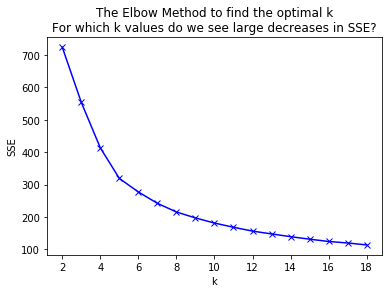

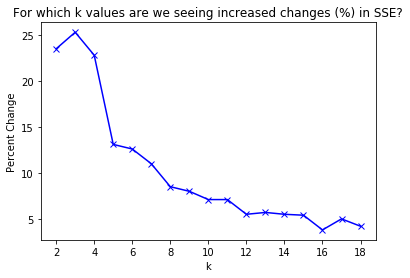

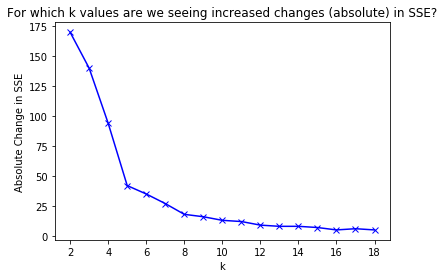

,k,sse,delta,pct_delta
0,2,723.30,170.00,23.50
1,3,553.10,140.00,25.30
2,4,412.92,94.00,22.80
3,5,318.79,42.00,13.10
4,6,277.05,35.00,12.60
5,7,242.05,27.00,11.00
6,8,215.37,18.00,8.50
7,9,197.05,16.00,8.00
8,10,181.19,13.00,7.10
9,11,168.27,12.00,7.10


In [9]:
find_k(X_train_scaled, cluster_vars, k_range)

In [20]:
k = 4

In [21]:
def create_clusters(X_train_scaled, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 13)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train[cluster_vars])

    return kmeans

In [25]:
kmeans = create_clusters(X_train_scaled[cluster_vars], k, cluster_vars)

In [26]:
# get the centroids for each distinct cluster...

def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df

In [30]:
centroid_df=get_centroids(kmeans, cluster_vars, cluster_name)

In [39]:
centroid_df

,area_cluster,centroid_land_dollar_per_sqft,centroid_tax_value,centroid_age
0,0,55.31,"592,579.56",43.57
1,1,111.34,"1,320,975.50",41.83
2,2,18.55,"223,381.65",51.37
3,3,210.75,"2,868,664.40",39.98


In [102]:
# label cluster for each observation in X_train (X[0] in our X list of dataframes), 
# X_validate (X[1]), & X_test (X[2])
D = [X_train_scaled, X_validate_scaled, X_test_scaled]

def assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df):
    for i in range(len(D)):
        clusters = pd.DataFrame(kmeans.predict(D[i][cluster_vars]), 
                            columns=[cluster_name], index=X[i].index)

        clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

        D[i] = pd.concat([D[i], clusters_centroids], axis=1)
    return D
D

[                  latitude            longitude                  age  \
 0                     0.59                 0.67                 0.46   
 1                     0.56                 0.52                 0.37   
 2                     0.45                 0.53                 0.32   
 3                     0.51                 0.58                 0.45   
 4                     0.59                 0.65                 0.44   
 ...                    ...                  ...                  ...   
 38830                 0.75                 0.57                 0.13   
 38831                 0.56                 0.61                 0.56   
 38832                 0.31                 0.79                 0.44   
 38833                 0.37                 0.84                 0.30   
 38834                 0.19                 0.98                 0.14   
 
        structure_tax_value            tax_value       land_tax_value  \
 0                     0.06                 0.18 

In [103]:
D=assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)

In [87]:
pd.DataFrame(centroid_df.groupby(['area_cluster', 'centroid_land_dollar_per_sqft', 'centroid_tax_value', 
                           'centroid_age'])['area_cluster'].value_counts())

,,,,,area_cluster
area_cluster,centroid_land_dollar_per_sqft,centroid_tax_value,centroid_age,area_cluster,
0,55.31,"592,579.56",43.57,0,1
1,111.34,"1,320,975.50",41.83,1,1
2,18.55,"223,381.65",51.37,2,1
3,210.75,"2,868,664.40",39.98,3,1


In [106]:
centroid_df['area_cluster']._counts()

3    1
2    1
1    1
0    1
Name: area_cluster, dtype: int64